In [1]:
from keras import backend as K
from keras.models import Sequential
from keras.models import load_model
from keras.layers import (
    Dense,
    Dropout,
    Flatten,
    Conv2D,
    MaxPool2D,
    BatchNormalization,
)

import cv2
import numpy as np

from skimage.filters import threshold_otsu
from skimage.measure import regionprops
from skimage import measure

import scipy.spatial as spatial
import matplotlib.patches as patches
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
MODEL_MNIST = 'model-mnist.hdf5'
MODEL_PLAT_INDO = 'model-plat-indo.hdf5'
MODEL_PLAT_INDO_DIGIT = 'model-plat-indo-digit-only.hdf5'
MODEL_ROZI = 'model-final-rozi.hdf5'
PLAT1 = 'plate-image/plat1.jpg'
PLAT2 = 'plate-image/plat2.jpg'
PLAT2_PLAT = 'plate-image/plat2-plat.jpg'
PLAT3 = 'plate-image/plat3.jpg'
PLAT4 = 'plate-image/plat4.jpg'

In [3]:
model = load_model(MODEL_PLAT_INDO)

In [4]:
def rotate_bound(image, angle):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH))

In [5]:
def resizeAndPad(img, size, padColor=0):

    h, w = img.shape[:2]
    sh, sw = size

    # interpolation method
    if h > sh or w > sw: # shrinking image
        interp = cv2.INTER_AREA
    else: # stretching image
        interp = cv2.INTER_CUBIC

    # aspect ratio of image
    aspect = w/h

    # compute scaling and pad sizing
    if aspect > 1: # horizontal image
        new_w = sw
        new_h = np.round(new_w/aspect).astype(int)
        pad_vert = (sh-new_h)/2
        pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
        pad_left, pad_right = 0, 0
    elif aspect < 1: # vertical image
        new_h = sh
        new_w = np.round(new_h*aspect).astype(int)
        pad_horz = (sw-new_w)/2
        pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
        pad_top, pad_bot = 0, 0
    else: # square image
        new_h, new_w = sh, sw
        pad_left, pad_right, pad_top, pad_bot = 0, 0, 0, 0

    # set pad color
    if len(img.shape) is 3 and not isinstance(padColor, (list, tuple, np.ndarray)): # color image but only one color provided
        padColor = [padColor]*3

    # scale and pad
    scaled_img = cv2.resize(img, (new_w, new_h), interpolation=interp)
    scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=padColor)

    return scaled_img

### Load Image

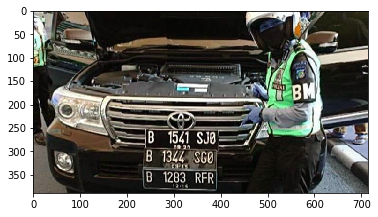

In [14]:
image = cv2.imread(PLAT3)
plt.imshow(image)
plt.show()

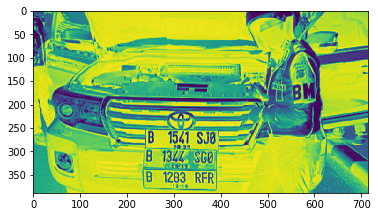

In [15]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.bitwise_not(gray)
plt.imshow(gray)
plt.show()

In [16]:
# threshold the image, setting all foreground pixels to
# 255 and all background pixels to 0
angle = 0

# the `cv2.minAreaRect` function returns values in the
# range [-90, 0); as the rectangle rotates clockwise the
# returned angle trends to 0 -- in this special case we
# need to add 90 degrees to the angle
# otherwise, just take the inverse of the angle to make
# it positive
if angle < -45:
    angle = -(90 + angle)
else:
    angle = -angle

(h, w) = image.shape[:2]
center = (w // 2, h // 2)
M = cv2.getRotationMatrix2D(center, angle, 1.0)
rotated = cv2.warpAffine(
    gray, M, (w, h),
    flags=cv2.INTER_CUBIC,
    borderMode=cv2.BORDER_REPLICATE
)

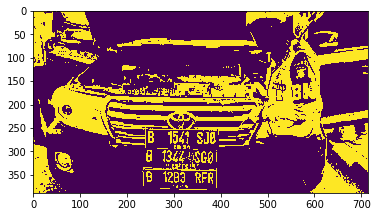

In [17]:
car_image = rotated
gray_car_image = car_image * 255
threshold_value = threshold_otsu(gray_car_image)
binary_car_image = gray_car_image > threshold_value

(thresh, binary_car_image) = cv2.threshold(
    gray_car_image,
    128,
    255,
    cv2.THRESH_BINARY | cv2.THRESH_OTSU
)
plt.imshow(binary_car_image)
plt.show()

In [18]:
# this gets all the connected regions and groups them together
label_image = measure.label(binary_car_image)

# getting the maximum width, height and minimum width and height that a license plate can be
plate_objects_cordinates = []
plate_like_objects = []
fig, (ax1) = plt.subplots(1)
ax1.imshow(gray_car_image, cmap="gray");

# regionprops creates a list of properties of all the labelled regions
crops = []
centers = []
chars = []
for region in regionprops(label_image):
    if region.area < 70 or region.area > 2000:
        # if the region is so small then it's likely not a license plate
        continue

    # the bounding box coordinates
    min_row, min_col, max_row, max_col = region.bbox
    region_height = max_row - min_row
    region_width = max_col - min_col
    char_ratio = float(region_width) / float(region_height)


    # ensuring that the region identified satisfies the condition of a typical licence char
    if 0.25 <= char_ratio <= 0.9 :
        chars.append({
            "min_row": min_row,
            "min_col": min_col,
            "max_row": max_row,
            "max_col": max_col
        })
        centers.append((int(min_col + max_col) / 2, int(min_row + max_row) / 2 ))

In [19]:
points = np.array(centers)
point_tree = spatial.cKDTree(points)

non_duplicate_center = []
query = point_tree.query_ball_point(centers, 30)
for q in query:
    for k in q:
        non_duplicate_center.append(centers[k])

non_duplicate_center = set(non_duplicate_center)

for char in chars:
    for ndc in non_duplicate_center:
        if (ndc[0] == int(char['min_col'] + char['max_col']) / 2 ) and (ndc[1] == int(char['min_row'] + char['max_row']) / 2 ):
            min_col = char['min_col']-1
            max_col = char['max_col']+1
            min_row = char['min_row']-1
            max_row = char['max_row']+1

            plate_like_objects.append(binary_car_image[min_row:max_row, min_col:max_col])
            plate_objects_cordinates.append((min_row, min_col, max_row, max_col))
            rect_border = patches.Rectangle(
                (min_col, min_row),
                max_col-min_col,
                max_row-min_row,
                edgecolor="red",
                linewidth=2,
                fill=False
            )
            ax1.add_patch(rect_border)

            crop = binary_car_image[min_row:max_row,min_col:max_col]
            crop = rotate_bound(crop, 90)
            resize_crop = resizeAndPad(crop, (28,28))
            crop = rotate_bound(resize_crop, -90)
            (thresh, crop) = cv2.threshold(crop, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

            to_append = {'x_min': min_col, 'y_min': min_row, 'crop': crop}
            crops.append(to_append)

In [20]:
PLATE_CHAR = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
             'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
             'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
             'U', 'V', 'W', 'X', 'Y', 'Z']

T W 8 0 W B 1 5 4 1 S J O 8 1 3 4 4 M G 8 5 8 3 Z 8 3 R F R 

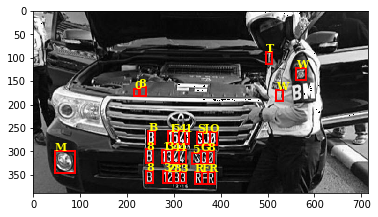

In [21]:
for c in crops:
    crop = c['crop']
    dim = (28, 28)
    res = cv2.resize(crop, dim, interpolation=cv2.INTER_LINEAR)
    data = np.array(res)
    flattened = data.flatten()
    flattened = flattened.reshape(1, flattened.shape[0])
    
    if flattened.shape[1] == 784:
        crop = cv2.resize(crop, dim)
        crop = np.array(crop)
        crop = crop.astype('float32')
        crop /= 255
        crop = np.expand_dims(crop, axis=0)
        crop = np.expand_dims(crop, axis=0)
        pr = (model.predict_classes(crop))

        char_index = pr[0]
        char = PLATE_CHAR[char_index]
        print(char, end=' ')
        x_min = c['x_min']
        y_min = c['y_min']
        font = {
                'family': 'serif',
                'color': 'yellow',
                'weight': 'bold',
                'size': 11,
                }
        plt.text(x_min, y_min, str(char), fontdict=font)

plt.show()